# XGBoost 

##Introduction:

XGBoost, eXtreme Gradient Boosting, is an optimised implementation of the Gradient Boosting model. It is a supervised learning, decision tree based ensemble machine learning algorithm that is known for its high performance and interpretability. It uses decision trees as base models and optimizes the gradient of the loss function to improve the model's performance. Each new tree built is trained to correct the errors of the previous tree. 

##How it works:

XGBoost basically works by building decision trees sequentially, where each tree tries to correct the mistakes made by the previous one to minimise the error as much as possible to get the best level of accuracy.

*Step by Step Process:*

- Initial Prediction: It starts with the first initial prediction, the base learner, where it is trained on the data supplied. During regression tasks it predicts the average of the target variable. 
- Error Calculation: After the first prediction is done, errors between the actual values and the predicted ones are calculated.
- Next Tree Training and Error Correction: The next tree will be trained on the errors of the previous tree, with the aim of minimizing the errors. It will attempt to correct the errors made by the previous tree. 
- Following Trees: This process is repeated over and over again with every new tree built. XGBoost uses the the predictions made by all the ensemble including the first one. it further improves the model's accuracy with every step. To make accurate predictions, XGBoost optimises the loss function by minimising it.
- Final Prediction: The process will keep on going until, the maximum number of trees is reached, the improvement in the loss function is minimal, or when it reaches the level of accuracy required. 

##Advantages:
1. High accuracy: XGBoost combines many models into one which helps in delivering better predictions.
2. Scalable: It can handle large datasets and and takes advantage of parallel processing to speed up the training process.
3. Flexible: It can be used for regression, calssifications, and ranking problems.
4. Interpretability: More complex than basic models, but allows you to see the feature importance, helping in identifying which factors most influence the prediction.


##Limitations:
1. Risk of Overfitting: Even with built-in regularization, XGBoost can still overfit if hyperparametersare not chosen carefully..
2. High Memory Usage: Its tree based structure can require a lot of memory, especially with very large datasets.
3. Not Ideal for Very Complex Data: On high-dimensional or sparse data, XGBoost may not perform as well as other models. 


In [59]:
#pip install xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

In [60]:
#pip install xgboost

Importing of libraries which are needed for the XGBoost machine learning algorithm. 

In [61]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, precision_recall_fscore_support, auc, ConfusionMatrixDisplay, make_scorer)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## 1. Data Prep & Encoding

This code performs data preparation for the machine learning model analysing traffic accident severity. This preprocessing transforms raw accident data into a numerical format suitable for machine learning algorithms.


In [62]:
df = pd.read_csv('combined_accidents_balanced.csv')

# Select Features
df_sel = df[['injury_severity', 'affected_party', 'primary_accident_type_code', 
             'rain_today', 'vehicle_type_score', 'age_min_encoded', 'rush_hour']].copy()

# Encoding
df_sel['injury_severity'] = df_sel['injury_severity'].map({'minor': 0, 'serious': 1, 'grievous': 1, 'death': 2})
df_sel['affected_party'] = df_sel['affected_party'].map({'pedestrian': 0, 'cyclist': 1, 'motorcyclist': 2, 'driver': 3})
df_sel['primary_accident_type_code'] = df_sel['primary_accident_type_code'].map({'FXOBJ': 0, 'PED': 1, 'COLL': 2, 'OTH': 3})
df_sel['rain_today'] = df_sel['rain_today'].astype(int)
df_sel['rush_hour'] = df_sel['rush_hour'].astype(int)

print("Class Counts (Original):")
print(df_sel['injury_severity'].value_counts().sort_index())

Class Counts (Original):
injury_severity
0     91
1    102
2     39
Name: count, dtype: int64


## 2. Split Data

The data then is split into training, validation, and test. Final ratio is set to 60% train / 20% validation / 20% test

In [63]:
X = df_sel.drop('injury_severity', axis=1)
y = df_sel['injury_severity']

# Stratified Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## 3. Apply SMOTE (Synthetic Minority Over-sampling)
We artificially generate new 'Death' samples only in the training set to help the model learn the boundary.
SMOTE was used to balance the imbalanced training data. The 'k_neighbors' was set low since we do not have a lot of "death" class sample.   

In [64]:
# SMOTE to balance the training classes
# k_neighbors=3 because we only have ~27 death samples
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Train Shape: {y_train.shape}")
print(f"Resampled Train Shape: {y_train_res.shape}")
print("\nResampled Class Distribution:")
print(y_train_res.value_counts())

Original Train Shape: (139,)
Resampled Train Shape: (183,)

Resampled Class Distribution:
injury_severity
1    61
2    61
0    61
Name: count, dtype: int64


## 4. Aggressive Class Weights
Even with SMOTE, we add extra weight to the Death class to force the model to prioritize it. Weights are used to make the model pay attention to certain injury severity classes during training, and as such it prioritises learming patterns that identify fatal accidents.

In [65]:
# Define manual weights to penalize Death errors more heavily
# 0 (Minor): 1.5
# 1 (Serious): 1
# 2 (Death): 2.0  <-- Heavy penalty for missing deaths

# Create weights for the resampled data
sample_weights = np.ones(len(y_train_res))
for idx, val in enumerate(y_train_res):
    if val == 0: sample_weights[idx] = 1.5
    if val == 1: sample_weights[idx] = 1
    if val == 2: sample_weights[idx] = 2

print("Weights configured.")

Weights configured.


## 5. Hyperparameter Optimization (Random Search)
#We search for parameters that maximize **Macro F1 Score** (average F1 of Minor, Serious, Death).
This part finds the optimal hyperparameters for the XGBoost model.

In [66]:
param_dist = {
    'n_estimators': [10, 30, 50, 100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# Macro F1 scorer
#scorer = make_scorer(f1_score, average='macro')
score = ["f1_macro"]

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,
    #scoring=scorer,
    scoring=score,
    cv=StratifiedKFold(n_splits=3),
    verbose=1,
    random_state=42,
    n_jobs=-1, refit="f1_macro"
)

print("Starting Hyperparameter Search...")
random_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)

best_model = random_search.best_estimator_
fit_time = random_search.cv_results_['mean_fit_time']
mean__fittime = np.mean(fit_time)

print("\nBest Parameters Found:")
print(random_search.best_params_)
print(f"Best CV Macro F1: {random_search.best_score_:.4f}")
print(f"Mean Fit Time: {mean__fittime:.4f}")



Starting Hyperparameter Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters Found:
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Best CV Macro F1: 0.6673
Mean Fit Time: 0.0633


## 6. Train XGBoost with Best Hyperparameters

In [67]:
#apply the best model on the validation set
# Get the best model from GridSearchCV and make predictions using the validation set

y_pred_rs = best_model.predict(X_val)

f1_scores_val = f1_score(y_val, y_pred_rs,average='macro')
bal_accuracy_val = balanced_accuracy_score(y_val, y_pred_rs)
accuracy_val = accuracy_score(y_val, y_pred_rs)
print("✓ Model Trained")
print(f"Best Model F1 Macro Score / Validation Set: {f1_scores_val:.2f}")
print(f"Best Model Balanced Accuracy / Validation Set: {bal_accuracy_val:.2f}")
print(f"Best Model Accuracy / Validation Set: {accuracy_val:.2f}")


✓ Model Trained
Best Model F1 Macro Score / Validation Set: 0.68
Best Model Balanced Accuracy / Validation Set: 0.71
Best Model Accuracy / Validation Set: 0.72


In [68]:
#apply the best model on the test set
y_test_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)

f1_scores = f1_score(y_test, y_test_pred ,average='macro')
bal_accuracy = balanced_accuracy_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
print("✓ Model Trained")
print(f"Best Model F1 Macro Score / Test Set: {f1_scores:.2f}")
print(f"Best Model Balanced Accuracy / Test Set: {bal_accuracy:.2f}")
print(f"Best Model Accuracy / Test Set: {accuracy:.2f}")

✓ Model Trained
Best Model F1 Macro Score / Test Set: 0.67
Best Model Balanced Accuracy / Test Set: 0.73
Best Model Accuracy / Test Set: 0.68


the model performs poorer on the test set

## 7. Final Evaluation

The final evaluation of the model will be done using the test set. The model will be evaluated using the support, precision, recall, and F1 score for each injury severity class. The model will also be evaluated using the confusion matrix and the classification report. The visualisation of the confusion matrix gives us a better view of the model's performance.

The confusion matrix below shows that:
1. Minor Injuries (18 in total): 14 correctly predicted (~78%), with 3 misclassified as Serious and 1 as Death
2. Serious Injuries (21 in total): 11 correctly predicted (~52%), with 1 misclassified as Minor and 9 as Death
3. Death (8 in total): 7 correctly predicted (~88%), with 1 misclassified as Serious



FINAL RESULTS
              precision    recall  f1-score   support

       Minor       0.93      0.78      0.85        18
     Serious       0.73      0.52      0.61        21
       Death       0.41      0.88      0.56         8

    accuracy                           0.68        47
   macro avg       0.69      0.73      0.67        47
weighted avg       0.76      0.68      0.69        47



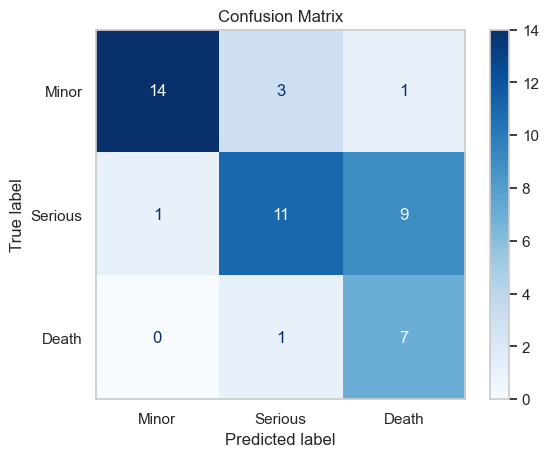

Death Cases Correctly Identified: 7/8 (87.5%)


In [69]:
# Apply optimal threshold to Test Set
print(f"\nFINAL RESULTS")
print("="*60)

print(classification_report(y_test, y_test_pred, target_names=['Minor', 'Serious', 'Death']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Minor', 'Serious', 'Death'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Confusion Matrix")
plt.show()

death_correct = cm[2,2]
death_total = cm[2].sum()
print(f"Death Cases Correctly Identified: {death_correct}/{death_total} ({death_correct/death_total:.1%})")

## 8. Comprehensive Performance Metrics

In [70]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
f1_macro = f1_score(y_test, y_test_pred, average='macro')
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Calculate ROC-AUC
y_probs = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='weighted')

print("=" * 70)
print("DETAILED PERFORMANCE METRICS")
print("=" * 70)
print(f"\nOverall Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")
print(f"  Macro F1: {f1_macro:.4f}")
print(f"  ROC-AUC (weighted): {roc_auc:.4f}")

print("\nPer-Class Performance:")
print("-" * 30)
class_names = ['Minor', 'Serious', 'Death']
for i, name in enumerate(class_names):
    print(f"{name:<10} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f}")
print("-" * 30)

DETAILED PERFORMANCE METRICS

Overall Performance:
  Accuracy: 0.6809
  Balanced Accuracy: 0.7255
  Weighted F1: 0.6933
  Macro F1: 0.6732
  ROC-AUC (weighted): 0.8989

Per-Class Performance:
------------------------------
Minor      | Precision: 0.9333 | Recall: 0.7778 | F1: 0.8485
Serious    | Precision: 0.7333 | Recall: 0.5238 | F1: 0.6111
Death      | Precision: 0.4118 | Recall: 0.8750 | F1: 0.5600
------------------------------


## 9. Permutation Feature Importance

This block calculates the permutation feature importance to determine which features mostly impacted the model performance. 

In [71]:
from sklearn.inspection import permutation_importance
features = np.array(X.columns)

result = permutation_importance(
    model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': features, 'Permutation Importance': result.importances_mean}).sort_values(
    'Permutation Importance', ascending=False)
perm_imp_df

,Feature,Permutation Importance
0,affected_party,0.221277
4,age_min_encoded,0.038298
2,rain_today,0.018440
5,rush_hour,0.013475
1,primary_accident_type_code,-0.010638
3,vehicle_type_score,-0.036879


## 10. ROC Curve

A ROC curve (Receiver Operating Characteristic curve) is a graph that shows how well a classification model separates classes. It plots the true positive rate (TPR) against the false positive rate (FPR) at different threshold settings. The diagonal dashed line represents random guessing, which in our case is 0.5. 

Curves which are closer to the top-left corner of the plot are considered better as they indicate a higher true positive rate and a lower false positive rate, thus better performance.

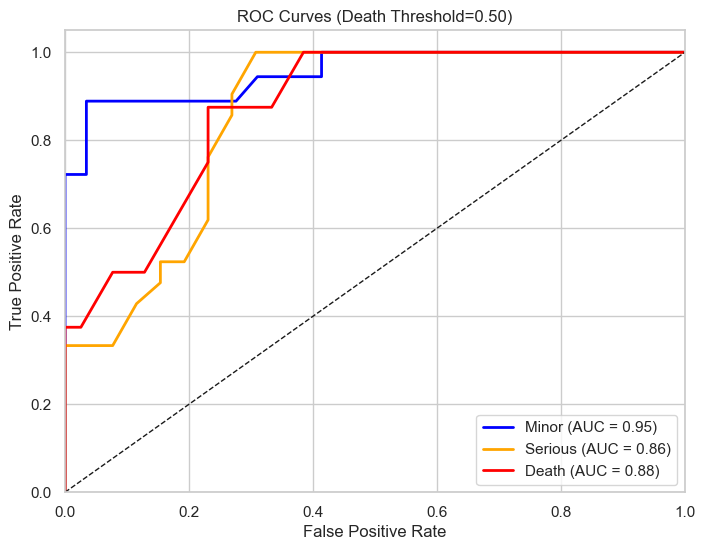

In [72]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2])  # Minor=0, Serious=1, Death=2

# Plot ROC curve
plt.figure(figsize=(8,6))
colors = ['blue', 'orange', 'red']
class_names = ['Minor','Serious','Death']

for i, color in zip(range(3), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Death Threshold={best_th:.2f})')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [73]:
#saving results into a separate df for comparisons

dfresults_labels = pd.Series(['F1Score','balanced_accuracy','accuracy','mean fit time'], name='Performance_Metrics:')
dfresults_values = pd.Series([f1_weighted, balanced_acc, accuracy, mean__fittime],name = 'XGBoost_Metrics_Values')
df_results = pd.concat([dfresults_labels, dfresults_values], axis =1)
df_results

metrics_file = "results/XGBoost_performance_metrics.csv"
df_results.to_csv(metrics_file, index=False)

#RF Y test values
XGBoost_Ytest_file = "results/XGBoost_Ytest.csv"
y_test.to_csv(XGBoost_Ytest_file, index=False)

#RF Y predicted values
XGBoost_Ypred_file = "results/XGBoost_Ypred.csv"
df_y_pred = pd.DataFrame(y_test_pred)
df_y_pred.to_csv(XGBoost_Ypred_file, index=False)

#Y prediction probabilities for the curve analysis
XGBoost_Yscore_file = "results/XGBoost_Y_pred_score.csv"
df_y_pred_score = pd.DataFrame(y_probs)
df_y_pred_score.to_csv(XGBoost_Yscore_file, index=False)

#permutation importance
XGBoost_perm_file = "results/XGBoost_Perm_Importance.csv"
perm_imp_df.to_csv(XGBoost_perm_file, index=False)

## Insights how XGBoost performed

The XGBoost classifier model demonstrates strong predictive capabilities for multi-class traffic accident severity classification, acheiving an overall accuracy of 68.09% and balanced accuracy of 68.09% and balanced accuracy of 72.55% accross three severity categories which where minor, serious, and death.


The classifier shows good performance classification, where the ROC-AUC scores of 0.95 for minor, 0.88 for serious, nd 0.86 for death. Since death was prioritised, the model identifies 7 of 8 of fatal accidents with an 87.5% accuracy. This fullfilled the primary objective of maximising death cases detection through weighted sampling and SMOTE techniques.


Permutation feature importance analysis reveals that the most influential feature was the affected party with a score of 0.221277. This shows that who is involved, whether is a pedestrian, cyclist, motorcyclist, or driver fundamentally determines injury severity. The affected party is then followed by the minimum age encoded, rain today, and rush hour with the scores of 0.038298, 0.018440, and 0.013475 respectively. 
Interestingly, primary accident type code and vehicle type score, demonstrate negative importance values with scores of -0.010638 and -0.036879 respectively. This might show that these two features potentially introduce noise into the predictions. This can negatively impact the overall results.
 

Per class analysis shows precision values of ~93% for minor, ~73% for serious, and ~41% for death, whilst corresponding recall rates are those of ~78%, ~52%, and ~88% respectively. 
Minor Injuries: The precision shows that the model is correct 93% of the time, which shows it's high reliability. when precision and recall all together are analysed, it shows a relatively high precision with minimal false alarms.
Serious Injuries: The weakest performance between the three classes where only 73% of serious predictions were correct, and cathes 52% of the cases only, this shows that the model seems to stuggle, making them hardest to classify.
Death: Out of 8 actual deaths, the model correctly predicted 7 of them, with an accuracy of 87.5%, which is a good performance, but it also mistakenly flaged 9 serious injuries as death cases. This is because the model was intentionally programmed with a weight of 2.0 to prioritise death cases thus being overcautious. 

In conclusion we can say that this model prediction is overcautious, but makes it preferable to over-prepare emergency resources for the less severe 9 cases which were mistakenly flagged to miss even one fatal accident. In life or death scenarios false alarms are acceptable, whereas missed fatalities are not.


### Limitations:

The major limitation for this model is the small dataset which was used. I beleive that if we had a larger dataset the results would be much better. The lack of detail that the local news and police reports can contribute to more false positives too since not all the details will be known and publicly available. 

Another limitation was that with the dataset provided, too few death cases were reported, which in turn the model had to have a bigger weight to compensate, consequently be overcautious. 

Noisy data also contributed to negatively impact the overall result. Even missing data from reports negatively impact the XGBoost model cause it can potentially make unreliable predictions. 

### Suggested improvements

1. Increase the dataset where death cases might be more for the model to improve pattern learning
2. Remove negative importance features.
3. More time to test maybe combining the XGBoost with other algorithms to get better prediction. 



